### Purpose of this document

You're looking at a Jupyter Notebook. This is an interactive script. It can be run in the browser either online or by downloading the `.ipynb` file and then running the command `jupyter notebook` from the command line. It requires Python 3.

Each code cell is editable. You run them in sequence, by typing `shift-enter`. Please only edit the cells in the sections that contain variables. You can make changes, run the notebook cells, check the output, then make changes again, re-run... 

#### Importing some libraries, and other preparations, for later use

In [22]:
import os
import math
import csv
from io import StringIO

## Part 1: Flight height and ground-sampling distance (GSD)

#### Variables - change only these 

Configuration options are: 'HySpex Husky WITH FEX', 'HySpex WITHOUT field extender', 'HySpex WITH field extender', 'HySpex WITH FEX AND FLIR'.

In [2]:
config_option = 'HySpex Husky WITH FEX'

## code below is for validation purposes
config_variants = 'HySpex Husky WITH FEX', 'HySpex WITHOUT field extender', 'HySpex WITH field extender', 'HySpex WITH FEX AND FLIR'
if config_option not in config_variants:
    raise Exception("Please select a valid configuration from the options.")

Enter flying height above mean sea level (ASL) in feet and flight speed in km/h.

In [3]:
flying_ASL_ft = 7500
flying_speed_kmph = 150

Enter highest and lowest elevation in target area in feet:

In [4]:
ele_max_ft = 2790
ele_min_ft = 500

#### Constants - **these should not need changing**

Let's first deal with the HySpex configuration in the aircraft

In [6]:
hyspex_csvstr = """Camera setup,X pixels,Y pixels,HFOV for swath,IFOV for VNIR GSD,IFOV for SWIR GSD
HySpex WITHOUT field extender,1800,1,0.28032,0.00032,0.00073
HySpex WITH field extender,1800,1,0.56064,0.00067,0.00146
HySpex WITH FEX AND FLIR,1800,1,0.436332312998582,0.00067,0.00146
HySpex Husky WITH FEX,1550,1,0.517575,0.00067,0.00146"""

reader = csv.DictReader(StringIO(hyspex_csvstr))
hyspex_dict = {rows.pop('Camera setup'):rows for rows in reader}

hfov_swath = float(hyspex_dict[config_option]['HFOV for swath'])
ifov_vnir = float(hyspex_dict[config_option]['IFOV for VNIR GSD'])
ifov_swir = float(hyspex_dict[config_option]['IFOV for SWIR GSD'])

In [7]:
meter_to_feet = 3.28083989501312        # conversion meters to feet
kmph_to_mph = 0.621371
kmph_to_knots = 0.539957

#### GSD check

Enter the target ground-sampling distance (GSD) in m. 

In [8]:
target_GSD_VNIR = 0.5

# Calculations
flying_height_AGL_target = target_GSD_VNIR / ifov_vnir

print(f"To attain your planned GSD, you should fly no higher than {flying_height_AGL_target:.1f} m (or {flying_height_AGL_target * meter_to_feet:.1f} ft)")

To attain your planned GSD, you should fly no higher than 746.3 m (or 2448.4 ft)


#### Derived quantities

You should normally not edit the following. Edit the original quantities in the previous section. 

In [9]:
flying_ASL_m = flying_ASL_ft / meter_to_feet
flying_AGL_ft_min = flying_ASL_ft - ele_max_ft
flying_AGL_ft_max = flying_ASL_ft - ele_min_ft
flying_AGL_m_min = flying_AGL_ft_min / meter_to_feet
flying_AGL_m_max = flying_AGL_ft_max / meter_to_feet
ele_min_m = ele_min_ft / meter_to_feet
ele_max_m = ele_max_ft / meter_to_feet

################

print("*** Flight parameters")
print(f"Flying height above sea level (ASL) in m: \t\t {flying_ASL_m:.1f}")
print(f"Minimum flying height above ground level (AGL) in ft: \t {flying_AGL_ft_min:.1f}")
print(f"Minimum flying height above ground level (AGL) in m: \t {flying_AGL_m_min:.1f}")
print(f"Maximum flying height above ground level (AGL) in ft: \t {flying_AGL_ft_max:.1f}")
print(f"Maximum flying height above ground level (AGL) in m: \t {flying_AGL_m_max:.1f}")
print(f"Minimum elevation AGL in target area in m: \t\t {ele_min_m:.1f}")
print(f"Maximum elevation AGL in target area in m: \t\t {ele_max_m:.1f}")
print(f"Flying speed in mph: \t\t\t\t\t {flying_speed_kmph * kmph_to_mph:.1f}")
print(f"Flying speed in knots: \t\t\t\t\t {flying_speed_kmph * kmph_to_knots:.1f}")
print()
print(f"*** Pixel size parameters")
print(f"VNIR GSD (min) in m: \t\t\t\t\t {flying_AGL_m_min*ifov_vnir:.1f}")
print(f"VNIR GSD (max) in m: \t\t\t\t\t {flying_AGL_m_max*ifov_vnir:.1f}")
print(f"SWIR GSD (min) in m: \t\t\t\t\t {flying_AGL_m_min*ifov_swir:.1f}")
print(f"SWIR GSD (max) in m: \t\t\t\t\t {flying_AGL_m_max*ifov_swir:.1f}")


*** Flight parameters
Flying height above sea level (ASL) in m: 		 2286.0
Minimum flying height above ground level (AGL) in ft: 	 4710.0
Minimum flying height above ground level (AGL) in m: 	 1435.6
Maximum flying height above ground level (AGL) in ft: 	 7000.0
Maximum flying height above ground level (AGL) in m: 	 2133.6
Minimum elevation AGL in target area in m: 		 152.4
Maximum elevation AGL in target area in m: 		 850.4
Flying speed in mph: 					 93.2
Flying speed in knots: 					 81.0

*** Swath parameters
Swath width (max) in m: 				 1104.3
Swath width (min) in m: 				 743.0
Max swath width with 40% sidelap in m: 			 662.6

*** Pixel size parameters
VNIR GSD (min) in m: 					 1.0
VNIR GSD (max) in m: 					 1.4
SWIR GSD (min) in m: 					 2.1
SWIR GSD (max) in m: 					 3.1


## Part 2: Swath and flightlines

### Target area

Enter flightline parameters. Start point is the start point of the first flightline. It can be in the NW, NE, SW, SE corner of the target area. First flightline direction can be N, S, E, W. 

In [25]:
flightline_length_km = 14
number_flightlines = 27
side_lap_percent = 40
start_corner = 'NW'
initial_direction = 'S'


## code below is for validation purposes
valid_directions = {
    'NW': ['S', 'E'],
    'NE': ['S', 'W'],
    'SW': ['N', 'E'],
    'SE': ['N', 'W']
}
try:
    if initial_direction not in valid_directions[start_corner]:
        raise Exception("Invalid initial direction")
except KeyError:
    raise Exception("Invalid start corner")

In [26]:
swath_width = flying_AGL_m_max * hfov_swath
swath_max_with_sidelap = swath_width * (100 - side_lap_percent) / 100

print()
print("*** Swath parameters")
print(f"Swath width (max) in m: \t\t\t\t {swath_width:.1f}")
print(f"Swath width (min) in m: \t\t\t\t {flying_AGL_m_min * hfov_swath:.1f}")
print(f"Max swath width with 40% sidelap in m: \t\t\t {swath_max_with_sidelap:.1f}")


*** Swath parameters
Swath width (max) in m: 				 1104.3
Swath width (min) in m: 				 743.0
Max swath width with 40% sidelap in m: 			 662.6


You don't *have* to edit the following, but in case the terrain is very rugged you may want to change the distance of the flightlines. 

In [27]:
flightline_dist_m = swath_max_with_sidelap

################## 
target_area_width_km = ((number_flightlines - 1.) * flightline_dist_m + swath_width) / 1000
print(f"The flightline distance has been set to: {flightline_dist_m:.1f} m")
print(f"From this we derive the following target area:")
print(f"Length of target area in flight direction: {flightline_length_km:.1f} km")
print(f"Width of target area across flight direction: {target_area_width_km:.1f} km")
print(f"Area covered: {flightline_length_km*target_area_width_km:.1f} sq km")

The flightline distance has been set to: 662.6 m
From this we derive the following target area:
Length of target area in flight direction: 14.0 km
Width of target area across flight direction: 18.3 km
Area covered: 256.6 sq km


At this stage, you might want to go back and change your initial parameters. 

### Flightline endpoints ready for GPS

Enter your start latitude and longitude:

In [11]:
lat0 = 65.248
lon0 = -147.692

First we define a series of helper functions:
  * to calculate new lat/lon based on old lat/lon, distance in km, and bearing in degrees
  * to set parameters for bearing of the flightline segments based on starting point and direction
  * to produce the list of waypoints for the start and end of the flightlines ("flightpoints")
  * to convert such a list to GPX (XML format)

In [23]:
R = 6378.1 # Radius of the Earth in km

def next_point(lat, lon, dist_km, bearing_deg):  
    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    lat2 = math.asin( 
        math.sin(lat1) * math.cos(dist_km/R) + 
        math.cos(lat1) * math.sin(dist_km/R) * math.cos(math.radians(bearing_deg)))
    lon2 = lon1 + math.atan2(
        math.sin(math.radians(bearing_deg)) * math.sin(dist_km/R) * math.cos(lat1), 
        math.cos(dist_km/R) - math.sin(lat1) * math.sin(lat2))

    return math.degrees(lat2), math.degrees(lon2)

def get_para(initial_direction, start_corner):
    flipflop_dict = {
        'E': {
            'j': 1,
            'a': 90,
            },
        'W': {
            'j': 0,
            'a': 90,
            },
        'N': {
            'j': 1,
            'a': 0,
            },
        'S': {
            'j': 0,
            'a': 0,
            },
    }
    progress_dict = {
        'EW': {
            'N': 180,
            'S': 0,
            },
        'NS': {
            'W': 90,
            'E': 270
        }
    }
    gen_dict = {
        'E': 'EW',
        'W': 'EW',
        'N': 'NS',
        'S': 'NS'
    }
    try:
        c = progress_dict[gen_dict[initial_direction]][start_corner[0]]
    except KeyError:
        c = progress_dict[gen_dict[initial_direction]][start_corner[1]]
    return flipflop_dict[initial_direction]['j'], flipflop_dict[initial_direction]['a'], c


def get_flightpoints(lat0=lat0, lon0=lon0, 
                     initial_direction=initial_direction, start_corner=start_corner,
                     number_flightlines=number_flightlines,
                     flightline_length_km=flightline_length_km,
                     prefix='PT'):
    flightpoints = [(prefix+"00", lat0, lon0)]
    jj, a, c = get_para(initial_direction, start_corner)
    for ii in range(1, number_flightlines):
        new_bearing = a + 180 * (ii + jj)
        newlat, newlon = next_point(*flightpoints[-1][1:], flightline_length_km, new_bearing)
        flightpoints.append((f"{prefix}{str(2*ii-1).zfill(2)}", newlat, newlon))
        new_bearing = c
        newlat, newlon = next_point(*flightpoints[-1][1:], flightline_dist_m/1000, new_bearing)
        flightpoints.append((f"{prefix}{str(2*ii).zfill(2)}", newlat, newlon))
    return flightpoints[:-1]

In [18]:
get_para('W', 'SE')

(0, 90, 0)

In [24]:
get_flightpoints()

[('PT00', 65.248, -147.692),
 ('PT01', 65.12223513065285, -147.692),
 ('PT02', 65.12223446394457, -147.6778514127303),
 ('PT03', 65.24799933329173, -147.6778514127303),
 ('PT04', 65.2479986627307, -147.66363549981094),
 ('PT05', 65.12223379338353, -147.66363549981094),
 ('PT06', 65.12223312667528, -147.64948691325336),
 ('PT07', 65.24799799602243, -147.64948691325336),
 ('PT08', 65.24799732546145, -147.63527100105364),
 ('PT09', 65.1222324561143, -147.63527100105364),
 ('PT10', 65.1222317894061, -147.62112241520816),
 ('PT11', 65.24799665875325, -147.62112241520816),
 ('PT12', 65.2479959881923, -147.6069065037281),
 ('PT13', 65.12223111884515, -147.6069065037281),
 ('PT14', 65.12223045213698, -147.5927579185948),
 ('PT15', 65.24799532148413, -147.5927579185948),
 ('PT16', 65.24799465092323, -147.5785420078344),
 ('PT17', 65.12222978157607, -147.5785420078344),
 ('PT18', 65.12222911486793, -147.5643934234132),
 ('PT19', 65.2479939842151, -147.5643934234132),
 ('PT20', 65.24799331365425,

In [32]:
flightpoints = get_flightpoints()
print('\n'.join([f"{pt[0]},{pt[1]},{pt[2]}" for pt in flightpoints]))

PT00,65.248,-147.692
PT01,65.12223513065285,-147.692
PT02,65.12223446394457,-147.6778514127303
PT03,65.24799933329173,-147.6778514127303
PT04,65.2479986627307,-147.66363549981094
PT05,65.12223379338353,-147.66363549981094
PT06,65.12223312667528,-147.64948691325336
PT07,65.24799799602243,-147.64948691325336
PT08,65.24799732546145,-147.63527100105364
PT09,65.1222324561143,-147.63527100105364
PT10,65.1222317894061,-147.62112241520816
PT11,65.24799665875325,-147.62112241520816
PT12,65.2479959881923,-147.6069065037281
PT13,65.12223111884515,-147.6069065037281
PT14,65.12223045213698,-147.5927579185948
PT15,65.24799532148413,-147.5927579185948
PT16,65.24799465092323,-147.5785420078344
PT17,65.12222978157607,-147.5785420078344
PT18,65.12222911486793,-147.5643934234132
PT19,65.2479939842151,-147.5643934234132
PT20,65.24799331365425,-147.55017751337246
PT21,65.12222844430708,-147.55017751337246
PT22,65.122227777599,-147.5360289296634
PT23,65.24799264694616,-147.5360289296634
PT24,65.247991976385

In [33]:
def get_gpx(flightpoints):

    ele = 0
    gpx_prefix = """<?xml version="1.0" encoding="utf-8" standalone="yes"?>
    <gpx version="1.1" creator="Alaska EPSCoR Fire and Ice https://epscor.alaska.edu/" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd">
    """
    gpx_suffix = "</gpx>"
    gpx_output = [gpx_prefix]

    for wptname, lat, lon in flightpoints:
        gpx_item = f"""<wpt lat="{lat}" lon="{lon}">
      <ele>{ele}</ele>
      <name>{wptname}</name>
    </wpt>"""
        gpx_output.append(gpx_item)
    gpx_output.append(gpx_suffix)
    return gpx_output


In [34]:
gpx_output = get_gpx(flightpoints)
print('\n'.join(gpx_output))

<?xml version="1.0" encoding="utf-8" standalone="yes"?>
    <gpx version="1.1" creator="Alaska EPSCoR Fire and Ice https://epscor.alaska.edu/" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd">
    
<wpt lat="65.248" lon="-147.692">
      <ele>0</ele>
      <name>PT00</name>
    </wpt>
<wpt lat="65.12223513065285" lon="-147.692">
      <ele>0</ele>
      <name>PT01</name>
    </wpt>
<wpt lat="65.12223446394457" lon="-147.6778514127303">
      <ele>0</ele>
      <name>PT02</name>
    </wpt>
<wpt lat="65.24799933329173" lon="-147.6778514127303">
      <ele>0</ele>
      <name>PT03</name>
    </wpt>
<wpt lat="65.2479986627307" lon="-147.66363549981094">
      <ele>0</ele>
      <name>PT04</name>
    </wpt>
<wpt lat="65.12223379338353" lon="-147.66363549981094">
      <ele>0</ele>
      <name>PT05</name>
    </wpt>
<wpt lat="65.12223312667528" lon="

Save GPX to file

In [56]:
filename = 'myflightpoints.gpx'
outpath = os.path.join('output/', filename)
with open(outpath, 'w') as dst:
    dst.write('\n'.join(gpx_output))

### Visualize reusulting flightpoints

This requires some more imports

In [36]:
import geopandas as gp
from shapely.geometry import LineString, Point

In [40]:
gis_pts = [Point(x, y) for _, y, x in flightpoints]
gis_line = LineString(gis_pts)

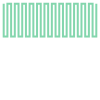

In [41]:
gis_line

In [42]:
pts_series = gp.GeoSeries(gis_pts)
line_series = gp.GeoSeries([gis_line])

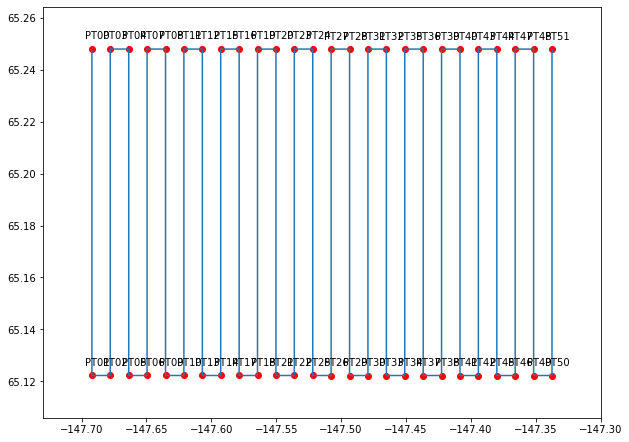

In [59]:
ax = line_series.plot(figsize=(10,8))
pts_series.plot(ax=ax, color='r')
ax.set_aspect(2)
bottom, top = ax.get_ylim()
left, right = ax.get_xlim()
ax.set_ylim(bottom - 0.01, top + 0.01)
ax.set_xlim(left - 0.02, right + 0.02)
for idx, pt in enumerate(pts_series):
    ax.annotate(flightpoints[idx][0], xy=(pt.x, pt.y), xytext=(-7, 10), textcoords="offset points")